## Import dependecies

In [1]:
import sys
import time
import warnings
import logging
import random
import json
from scipy import stats
from os.path import join, basename, splitext, isfile
from os import listdir
from collections import OrderedDict

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import cooler
import cooltools

import hichew
from hichew.calling import boundaries, domains, clusters
from hichew.compute import normalize, d_scores, insulation_scores, silhouette
from hichew.loader import cool_files
from hichew.plot import clusters_dynamics, viz_opt_curves, viz_tads, _pca, _tsne


/Users/encent/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import logging
import time
import operator
import os
import sys
import warnings

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, AffinityPropagation, MeanShift

from hichew.lib import utils

In [3]:
sns.set(context='paper', style='whitegrid')
warnings.filterwarnings("ignore")

In [4]:
%matplotlib inline

In [41]:
# by D.Skvortsov (NOT yet revised!)

def overlap_v1(data_1, data_2, delta=0, resolution=10000):
    # data_1: list of starts of boundaries/fountains of rep1
    # data_2: list of starts of boundaries/fountains of rep2
    # delta: shift value in a number of bins
    
    cap_total=set()
    cup_total=set()
    if delta != 0:
        D=resolution*delta
        shift=[D]*len(data_1)
        shift_plus_data_1=set([x+y for x, y in zip(data_1, shift)])
        shift_minus_data_1=set([x-y for x, y in zip(data_1, shift)])

        data_1=set(data_1)
        data_2=set(data_2)

        cup=data_1.union(data_2)
        cup_plus=shift_plus_data_1.intersection(data_2)
        cup_minus=shift_minus_data_1.intersection(data_2)
        cup_all=cup.difference(cup_plus).difference(cup_minus)
        cup_total=cup_total.union(cup_all)


        cap=data_1.intersection(data_2)
        cap_plus=shift_plus_data_1.intersection(data_2)
        cap_minus=shift_minus_data_1.intersection(data_2)

        cap_all=set.union(cap, cap_plus, cap_minus)
        cap_total=cap_total.union(cap_all)
    else:
        data_1=set(data_1)
        data_2=set(data_2)
        cup_total=data_1.union(data_2)
        cap_total=data_1.intersection(data_2)
    U=len(cup_total)
    A=len(cap_total)
    return A, U

def J_index(df_boundaries, df_fountains, delta=0, resolution=10000, chromosomes=['chr1']):
    A_cumsum = 0
    U_cumsum = 0
    for ch in chromosomes:
        data_1 = list(df_boundaries[df_boundaries.ch == ch]['bgn'])
        data_2 = list(df_fountains[df_fountains.ch == ch]['bgn'])
        A, U = overlap_v1(data_1, data_2, delta=delta, resolution=resolution)
        A_cumsum += A
        U_cumsum += U
    
    if U_cumsum != 0:
        return A_cumsum / U_cumsum
    else:
        return 0.

In [6]:
# by TADbit
# TBD

In [15]:
def draw_overlap_heatmap(table, xlabels=None, ylabels=None):
    plt.figure(figsize=(15,10))
    mat = np.asarray(table.values)
    print(mat)
    ax = sns.heatmap(mat, annot=True, cmap='Blues', fmt='.2%', annot_kws={"size": 20})

    ax.set_xlabel('{}\n'.format('boundaries'), fontsize = 30)
    ax.set_ylabel('{}\n'.format('fountains'), fontsize = 30);
    #ax.set_ylabel('{}\n'.format('boundaries #2'), fontsize = 30);

    ## Ticket labels - List must be in alphabetical order
    if xlabels is None:
        ax.xaxis.set_ticklabels(list(table.columns), fontsize = 25)
    else:
        ax.xaxis.set_ticklabels(xlabels, fontsize = 25)
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    if ylabels is None:
        ax.yaxis.set_ticklabels(list(table.index), fontsize = 25)
    else:
        ax.yaxis.set_ticklabels(ylabels, fontsize = 25)
     
    ax.set_title('J-index * 100 with delta=1 bin\n', fontsize = 40);
    plt.show()


## Specify parameters

In [21]:
resolution = 10000

fountains_path = '../data/fountains/{}.bed'
#fountains_path = '../data/boundaries/filtered/{}.csv'
boundaries_path = '../data/boundaries/filtered/{}.csv'
coolers_path = '../data/coolers/This2022/{}.mcool'

stages_fountains = ['Wild-Type_2.75.danrer11-reduced.mapq_30.1000', 
                    'WT.danrer11-reduced.mapq_30.1000', 
                    'TR.danrer11-reduced.mapq_30.1000', 
                    'Wild-Type_11.danrer11-reduced.mapq_30.1000', 
                    'Wild-Type_25.danrer11-reduced.mapq_30.1000']
ylabels = ['2.75 hr', 'WT', 'TR', '11 hr', '25 hr']

#stages_fountains = ['sperm.danrer11-reduced.mapq_30.1000', 
#                     'Wild-Type_2.75.danrer11-reduced.mapq_30.1000', 
#                     'WT.danrer11-reduced.mapq_30.1000', 
#                     'TR.danrer11-reduced.mapq_30.1000', 
#                     'Wild-Type_5.3.danrer11-reduced.mapq_30.1000', 
#                     'Wild-Type_11.danrer11-reduced.mapq_30.1000', 
#                     'Wild-Type_25.danrer11-reduced.mapq_30.1000']
#ylabels = ['sperm', '2.75 hr', 'WT', 'TR', '5.3 hr', '11 hr', '25 hr']

stages_boundaries = ['sperm.danrer11-reduced.mapq_30.1000', 
                     'Wild-Type_2.75.danrer11-reduced.mapq_30.1000', 
                     'WT.danrer11-reduced.mapq_30.1000', 
                     'TR.danrer11-reduced.mapq_30.1000', 
                     'Wild-Type_5.3.danrer11-reduced.mapq_30.1000', 
                     'Wild-Type_11.danrer11-reduced.mapq_30.1000', 
                     'Wild-Type_25.danrer11-reduced.mapq_30.1000']
xlabels = ['sperm', '2.75 hr', 'WT', 'TR', '5.3 hr', '11 hr', '25 hr']

stages_all = ['sperm.danrer11-reduced.mapq_30.1000', 
              'Wild-Type_2.75.danrer11-reduced.mapq_30.1000', 
              'WT.danrer11-reduced.mapq_30.1000', 
              'TR.danrer11-reduced.mapq_30.1000', 
              'Wild-Type_5.3.danrer11-reduced.mapq_30.1000', 
              'Wild-Type_11.danrer11-reduced.mapq_30.1000', 
              'Wild-Type_25.danrer11-reduced.mapq_30.1000']


## Get data

#### Chromosomes

In [17]:
# chromosome armsizes

chromosome_armsizes_path = '../data/genome/danRer11.armsizes.txt'
chromosome_armsizes_data = pd.read_csv(chromosome_armsizes_path)
chromosome_armsizes_data = chromosome_armsizes_data.iloc[:-1]
chromosomes = list(chromosome_armsizes_data.chrom.drop_duplicates())

#### Coolers

In [18]:
# matrices, coolers = cool_files(stage_to_call, resolution=resolution, chromnames=chromosomes)

#### Fountains

In [37]:
fountains_dict = dict.fromkeys(stages_fountains, None)
for stage in stages_fountains:
    #fountains_data = pd.read_csv(fountains_path.format(stage))
    fountains_data = pd.read_csv(fountains_path.format(stage), sep='\t', header=None)
    fountains_data.columns = ['ch', 'start', 'end', 'unknown', 'sim']
    fountains_dict[stage] = fountains_data

#### Boundaries

In [38]:
boundaries_dict = dict.fromkeys(stages_boundaries, None)
for stage in stages_boundaries:
    boundaries_data = pd.read_csv(boundaries_path.format(stage))
    boundaries_dict[stage] = boundaries_data

## Calculate J-index for each pair of boundaries/fountains stages


In [42]:
j_index_df = pd.DataFrame(0., index=stages_fountains, columns=stages_boundaries)

In [43]:
for f_stage in stages_fountains:
    f_data = fountains_dict[f_stage]
    for b_stage in stages_boundaries:
        b_data = boundaries_dict[b_stage]
        J = J_index(b_data, f_data, delta=1, resolution=resolution, chromosomes=chromosomes)
        j_index_df.loc[f_stage, b_stage] = J

KeyError: 'bgn'

In [103]:
j_index_df

,sperm.danrer11-reduced.mapq_30.1000,Wild-Type_2.75.danrer11-reduced.mapq_30.1000,WT.danrer11-reduced.mapq_30.1000,TR.danrer11-reduced.mapq_30.1000,Wild-Type_5.3.danrer11-reduced.mapq_30.1000,Wild-Type_11.danrer11-reduced.mapq_30.1000,Wild-Type_25.danrer11-reduced.mapq_30.1000
sperm.danrer11-reduced.mapq_30.1000,1.000000,0.228361,0.101917,0.135205,0.125502,0.115610,0.102827
Wild-Type_2.75.danrer11-reduced.mapq_30.1000,0.228361,1.000000,0.125190,0.142636,0.136160,0.117715,0.106885
WT.danrer11-reduced.mapq_30.1000,0.101917,0.125190,1.000000,0.271861,0.358228,0.247538,0.193255
TR.danrer11-reduced.mapq_30.1000,0.135205,0.142636,0.271861,1.000000,0.291082,0.264065,0.207055
Wild-Type_5.3.danrer11-reduced.mapq_30.1000,0.125502,0.136160,0.358228,0.291082,1.000000,0.246713,0.195749
Wild-Type_11.danrer11-reduced.mapq_30.1000,0.115610,0.117715,0.247538,0.264065,0.246713,1.000000,0.325624
Wild-Type_25.danrer11-reduced.mapq_30.1000,0.102827,0.106885,0.193255,0.207055,0.195749,0.325624,1.000000


* 5.3 vs. WT = 36%
* 5.3 vs. TR = 29%


* 5.3 vs. sperm = 13%
* 5.3 vs. 2.75 = 14%
* 5.3 vs. 11 = 25%
* 5.3 vs. 25 = 20%

[[1.         0.22836096 0.10191726 0.13520541 0.12550201 0.11561033
  0.10282651]
 [0.22836096 1.         0.12519007 0.14263646 0.1361596  0.11771495
  0.10688493]
 [0.10191726 0.12519007 1.         0.27186075 0.3582284  0.24753805
  0.19325502]
 [0.13520541 0.14263646 0.27186075 1.         0.29108175 0.26406534
  0.20705521]
 [0.12550201 0.1361596  0.3582284  0.29108175 1.         0.24671341
  0.19574944]
 [0.11561033 0.11771495 0.24753805 0.26406534 0.24671341 1.
  0.32562442]
 [0.10282651 0.10688493 0.19325502 0.20705521 0.19574944 0.32562442
  1.        ]]


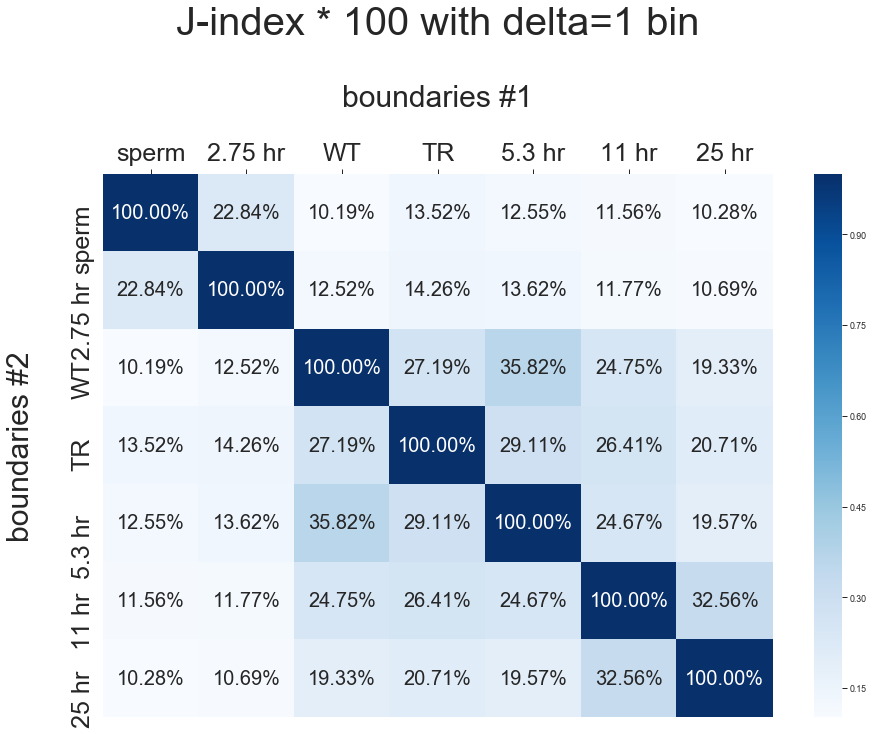

In [109]:
draw_overlap_heatmap(j_index_df, xlabels=xlabels, ylabels=ylabels)

**All table: less than 1% overlap between fountains and boundaries for each pair of stages (% = 100 * J-index)**

**First row: fountains found on 2.75 hr stage tend to be more overlapped with TAD boundaries.**

**First-Second column: TAD boundaries found on sperm & 2.75 hr stages tend to be more overlapped with fountains.**